# Transfer Learning in TensorFlow Part 1: Feature Extraction

```
Surely someone has spent the time crafting the right model for the job
```

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

Use cases:
1. Computer vision (Imagenet)
2. Natural Language Processing

Why transfer learning?
1. Can leverage an existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working network architecture which has already learned patterns on similar data to our own (often results in great results with less data)

What we're going to cover
1. Introduce transfer learning with TensorFlow
2. Using a small dataset to experiment fast (10% of training samples)
3. Building a transfer learning feature extraction model with TensorFlow Hub
4. Use TensorBoard to track modelling experiments and results.

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf

tf.__version__

'2.8.2'

In [10]:
!nvidia-smi

Sun Jul  3 08:16:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [11]:
import zipfile
import os

if os.path.exists("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent.zip") == False:
  !curl "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip" --output "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent.zip"

zip_file = zipfile.ZipFile("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent.zip")
zip_file.extractall("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification")
zip_file.close()

In [12]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent"):
  print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')

There are 2 directories and 0 files in /content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent
There are 10 directories and 0 files in /content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/test
There are 0 directories and 250 files in /content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 files in /content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 files in /content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/test/steak
There are 0 directories and 250 files in /content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/test/sushi
There are 0 directories and 250 files in /content/drive/MyDrive/Te

In [13]:
# Create data loaders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_augmented = ImageDataGenerator(
    rotation_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    rescale = 1./255,
    validation_split = 0.2
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_dir = "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/train"
test_dir = "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/test"

train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_dir, 
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = "training"
)

valid_data = valid_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = "validation"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,
)

Found 600 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

1. Tracking experiments with the TensorBoard callback
2. Model checkpoint with the ModelCheckpoint callback
3. Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.

|Callback Name|Use case|Code|
|-------------|--------|----|
|TensorBoard|Log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data|tf.keras.callbacks.TensorBoard()|
|Model checkpointing|Save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting|tf.keras.callbacks.ModelCheckpoint()|
|Early Stopping|Leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take|tf.keras.callbacks.EarlyStopping()|

In [14]:
# Create TensorBoard callback (functionalized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

**🔑 Note:** You can customize the directory where your TensorBoard logs (model training metrics get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating Models Using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

What is TensorFlow Hub?

A place to find a plethora of pre-trained machine learning models (ready to be applied and fine-tuned for your own problems)

In [16]:
# Lets compare the following two models.

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [17]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [18]:
# Lets make a create_model() function to create a model from a URL

def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes;default 10.
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a keras layers
  feature_extractor_layer = hub.KerasLayer(model_url, trainable = False, name = "feature_extractor_layer", input_shape = (224,224,3))
  model = Sequential(
      [
       feature_extractor_layer,
       tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")
      ]
  )
  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction Model

In [20]:
# Create a resnet model
resnet_model = create_model(resnet_url, num_classes = 10)

In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
# Compile the model
resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
resnet_history = resnet_model.fit(
    train_data_augmented,
    epochs = 5,
    steps_per_epoch = len(train_data_augmented),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    callbacks = [create_tensorboard_callback(dir_name = "/content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification", experiment_name = "resnet50V2")]
)

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification/resnet50V2/20220703-090349
Epoch 1/5
19/19 [==============================] - 12s 583ms/step - loss: 0.5053 - accuracy: 0.8350 - val_loss: 1.0658 - val_accuracy: 0.6600
Epoch 2/5
19/19 [==============================] - 11s 558ms/step - loss: 0.4043 - accuracy: 0.8900 - val_loss: 1.0361 - val_accuracy: 0.6600
Epoch 3/5
19/19 [==============================] - 10s 546ms/step - loss: 0.3291 - accuracy: 0.9317 - val_loss: 1.0700 - val_accuracy: 0.6533
Epoch 4/5
19/19 [==============================] - 10s 547ms/step - loss: 0.2860 - accuracy: 0.9417 - val_loss: 1.0510 - val_accuracy: 0.6467
Epoch 5/5
19/19 [==============================] - 11s 567ms/step - loss: 0.2566 - accuracy: 0.9400 - val_loss: 1.0382 - val_accuracy: 0.6600


Clearly overfitting but we've reduced training data by a lot so that should be expected at this point. Whats amazing is the accuracy we've managed to achieve with just a fraction of the train data.

In [25]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 16s 206ms/step - loss: 0.6565 - accuracy: 0.7900


[0.6565341949462891, 0.7900000214576721]

In [26]:
resnet_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plotting the loss curves

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_curves(history, figsize = (10,10)):
  """
  Plots the train and validation loss and accuracy curves
  Args:
    history: Output from the .fit method of tensorflow models
    figsize: Size of the graphs
  Returns:
    None
  """
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.figure(figsize = figsize)
  plt.plot(range(len(train_loss)), train_loss, label = "train_loss")
  plt.plot(range(len(val_loss)), val_loss, label = "validation_loss")
  plt.title("Loss Curve")
  plt.xlabel("Epoch ➡")
  plt.ylabel("Loss➡")
  plt.legend()

  plt.figure(figsize = figsize)
  plt.plot(range(len(train_accuracy)), train_accuracy, label = "train_accuracy")
  plt.plot(range(len(val_accuracy)), val_accuracy, label = "validation_accuracy")
  plt.title("Accuracy Curve")
  plt.xlabel("Epoch ➡")
  plt.ylabel("Accuracy➡")
  plt.legend()
  return None

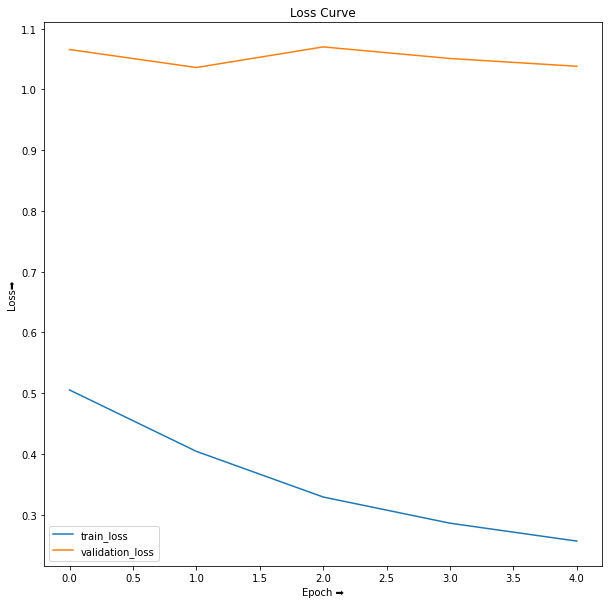

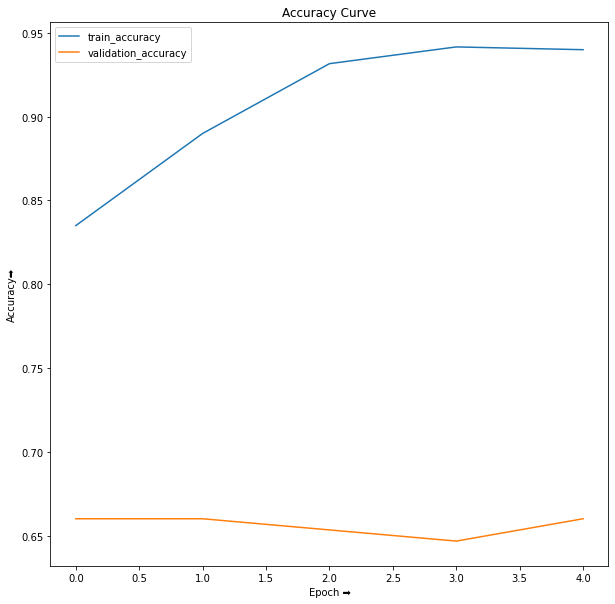

In [32]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [40]:
efficientnet_feature_extraction_layer = create_model(efficientnet_url, 10)

efficientnet_model = Sequential(
    [
     efficientnet_feature_extraction_layer,
     tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")
    ], name = "efficientnet_model"
)

efficientnet_model.summary()

Model: "efficientnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 10)                4062374   
                                                                 
 output_layer (Dense)        (None, 10)                110       
                                                                 
Total params: 4,062,484
Trainable params: 12,920
Non-trainable params: 4,049,564
_________________________________________________________________


In [41]:
# Compile the model
efficientnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_effnet = efficientnet_model.fit(
    train_data_augmented,
    epochs = 5,
    steps_per_epoch = len(train_data_augmented),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    callbacks = [create_tensorboard_callback(dir_name="/content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification", experiment_name="efficientnetb0")]
)

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification/efficientnetb0/20220703-094922
Epoch 1/5
19/19 [==============================] - 20s 594ms/step - loss: 2.2540 - accuracy: 0.2000 - val_loss: 2.2053 - val_accuracy: 0.3267
Epoch 2/5
19/19 [==============================] - 11s 567ms/step - loss: 2.1407 - accuracy: 0.4983 - val_loss: 2.1326 - val_accuracy: 0.4667
Epoch 3/5
19/19 [==============================] - 11s 556ms/step - loss: 2.0650 - accuracy: 0.5783 - val_loss: 2.0807 - val_accuracy: 0.5133
Epoch 4/5
19/19 [==============================] - 10s 551ms/step - loss: 2.0135 - accuracy: 0.6033 - val_loss: 2.0390 - val_accuracy: 0.5533
Epoch 5/5
19/19 [==============================] - 10s 544ms/step - loss: 1.9660 - accuracy: 0.6433 - val_loss: 2.0038 - val_accuracy: 0.5533


In [42]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 16s 204ms/step - loss: 1.9521 - accuracy: 0.6480


[1.9520903825759888, 0.6480000019073486]

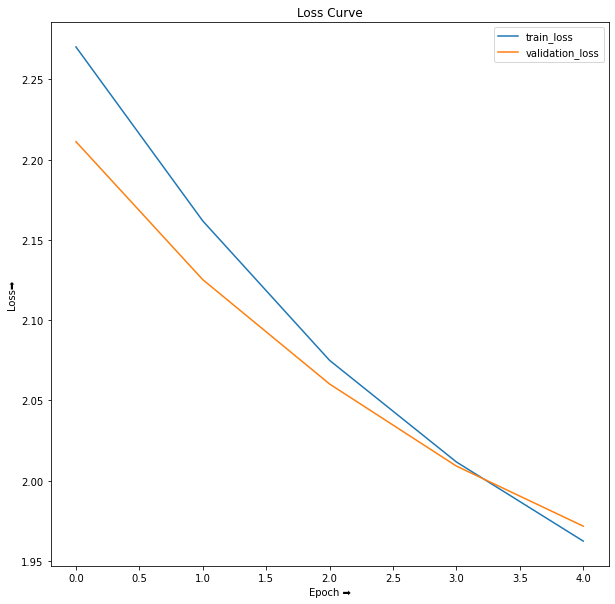

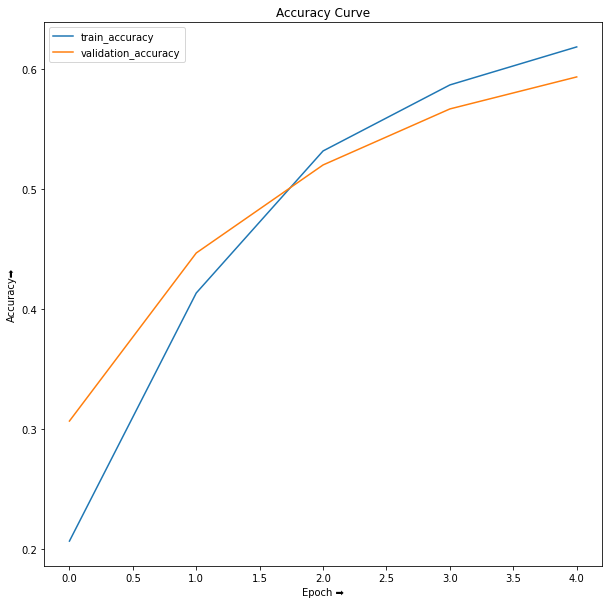

In [39]:
plot_loss_curves(history_effnet)

Atleast one major improvement I'm seeing here is that overfitting hasn't happened. While accuracy isn't as good as resnet, the model has the potential to be trained over more epochs to improve accuracy without running into diverging loss curves.

## Different Types of transfer learning

1. **"As is" transfer learning** - using an existing model with no changes whatsoever (eg using ImageNet model on 1000 ImageNet classes, none of your own)
2. **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (eg EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (eg. 1000 classes -> 10 classes of food)
3. **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [44]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

311

## Comparing our model results using TensorBoard

A way to visually explore your machine learning models performance and internals

Host, track and share your machine learning experiments on TensorBoard.dev (TensorBoard also integrates with websites like weights and biases)

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments do NOT upload them to TensorBoard.dev

In [45]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir "/content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification" \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&

In [46]:
!tensorboard dev list

https://tensorboard.dev/experiment/t5hyIWxFRZmTaCWJr5vVTw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   t5hyIWxFRZmTaCWJr5vVTw
	Created              2022-07-03 10:16:42 (2 minutes ago)
	Updated              2022-07-03 10:16:44 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5830687
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id t5hyIWxFRZmTaCWJr5vVTw